In [2]:
! pip install pandas numpy chardet scikit-learn matplotlib

===== Movie Review Sentiment Analysis Example =====
Data Check:
                              review     label
0  이 영화는 정말 재미있었습니다. 배우들의 연기가 훌륭했어요.  positive
1              최악의 영화였습니다. 시간 낭비였어요.  negative
2              스토리가 감동적이고 음악도 좋았습니다.  positive
3                   지루하고 재미없는 영화였어요.  negative
4           연출이 뛰어나고 배우들의 연기도 좋았습니다.  positive

After Label Conversion:
label
1    5
0    5
Name: count, dtype: int64

Training Data Size: 7
Testing Data Size: 3

Number of Extracted Features (Words): 29
Sample Features (Words):
['감동적이고' '감동적인' '내내' '너무' '뛰어나고' '배우들의' '보는' '뻔했고' '스토리가' '스토리와' '연기가'
 '연기도' '연출이' '영상미가' '영화' '영화는' '영화였어요' '음악도' '인상적이었습니다' '재미없는' '재미없었습니다'
 '재미있었습니다' '정말' '졸았어요' '좋았습니다' '지루하고' '지루했어요' '훌륭한' '훌륭했어요']

Prediction Results Sample:
Review: 연기력과 스토리 모두 만족스러웠습니다.
Actual Class: Positive
Predicted Class: Positive
Probability: Negative=0.4286, Positive=0.5714

Review: 최악의 영화였습니다. 시간 낭비였어요.
Actual Class: Negative
Predicted Class: Positive
Probability: Negative=0.4286, Posi

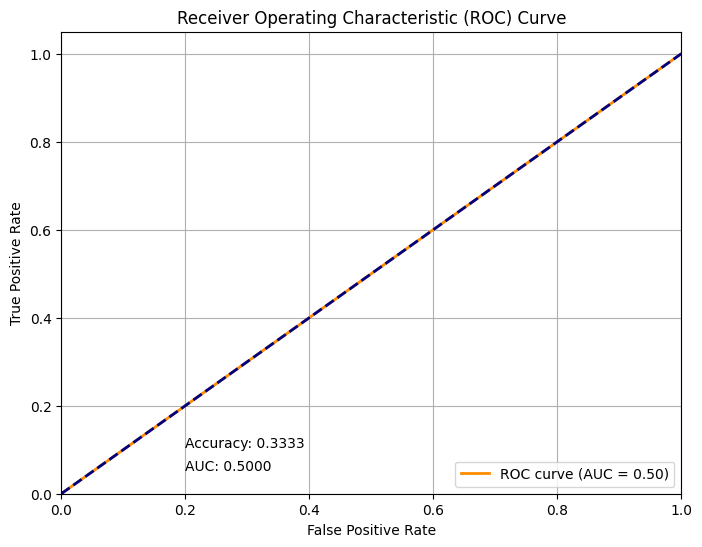


New Review Predictions:
Review: 이 영화는 정말 재미있었고 감동적이었습니다. 배우들의 연기도 훌륭했어요.
Prediction: Positive
Probability: Negative=0.0367, Positive=0.9633

Review: 시간 낭비였습니다. 스토리도 없고 연기도 별로였어요.
Prediction: Positive
Probability: Negative=0.3095, Positive=0.6905

Review: 생각보다 재미있었어요. 기대 이상이었습니다.
Prediction: Positive
Probability: Negative=0.4286, Positive=0.5714


===== Random Data Example =====
Generated Random Data:
   feature1  feature2  feature3  feature4
0         3         4         2         4
1         4         1         2         2
2         2         4         3         2
3         4         1         3         1
4         3         4         0         3
5         1         4         3         0
Target Values: [1 2 3 4 5 6]

4th Data Sample: [4 1 3 1]
Actual Target Value: 4
Predicted Target Value: 4

All Data Prediction Results:
Actual Values: [1 2 3 4 5 6]
Predicted Values: [1 2 3 4 5 6]


In [4]:
# 필요한 라이브러리 가져오기
import pandas as pd
import numpy as np
import chardet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# 인코딩 자동 감지 함수
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(1000000))
    return result['encoding']

# 모델 성능 시각화 함수
def performance(y_test, y_pred_proba, threshold=0.5, plot=True, anotation=True):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"정확도: {accuracy:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        
        if anotation:
            plt.annotate(f'Accuracy: {accuracy:.4f}', xy=(0.2, 0.1), xycoords='axes fraction')
            plt.annotate(f'AUC: {roc_auc:.4f}', xy=(0.2, 0.05), xycoords='axes fraction')
        
        plt.show()
    
    return accuracy, roc_auc

# 1. 영화 리뷰 감성 분석 예제
print("===== Movie Review Sentiment Analysis Example =====")

# 데이터 로드 (실제 파일 사용 시)
# file_path = 'movie_reviews.csv'
# encoding = detect_encoding(file_path)
# df = pd.read_csv(file_path, encoding=encoding)

# 예시 데이터 생성 (실제 데이터가 없는 경우)
reviews = [
    "이 영화는 정말 재미있었습니다. 배우들의 연기가 훌륭했어요.",
    "최악의 영화였습니다. 시간 낭비였어요.",
    "스토리가 감동적이고 음악도 좋았습니다.",
    "지루하고 재미없는 영화였어요.",
    "연출이 뛰어나고 배우들의 연기도 좋았습니다.",
    "기대했던 것보다 많이 실망스러웠어요.",
    "감동적인 스토리와 훌륭한 영상미가 인상적이었습니다.",
    "스토리가 너무 뻔했고 지루했어요.",
    "연기력과 스토리 모두 만족스러웠습니다.",
    "영화 보는 내내 졸았어요. 재미없었습니다."
]
labels = ["positive", "negative", "positive", "negative", "positive", 
          "negative", "positive", "negative", "positive", "negative"]

# 데이터프레임 생성
df = pd.DataFrame({'review': reviews, 'label': labels})
print("Data Check:")
print(df.head())

# negative를 0, positive를 1로 변환
df['label'] = df['label'].map({'negative': 0, 'positive': 1})
print("\nAfter Label Conversion:")
print(df['label'].value_counts())

# 훈련 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['label'], test_size=0.3, random_state=42
)

print(f"\nTraining Data Size: {len(X_train)}")
print(f"Testing Data Size: {len(X_test)}")

# CountVectorizer를 사용한 특성 추출
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)

# 추출된 특성(단어) 확인
print(f"\nNumber of Extracted Features (Words): {len(count_vectorizer.get_feature_names_out())}")
print("Sample Features (Words):")
print(count_vectorizer.get_feature_names_out())

# 테스트 데이터 변환
X_test_counts = count_vectorizer.transform(X_test)

# MultinomialNB 모델 생성 및 훈련
nb_model = MultinomialNB()
nb_model.fit(X_train_counts, y_train)

# 예측
y_pred = nb_model.predict(X_test_counts)
y_pred_proba = nb_model.predict_proba(X_test_counts)[:, 1]  # 긍정 클래스의 확률

# 모델 평가
print("\nPrediction Results Sample:")
for i in range(min(3, len(X_test))):
    print(f"Review: {X_test.iloc[i]}")
    print(f"Actual Class: {'Positive' if y_test.iloc[i] == 1 else 'Negative'}")
    print(f"Predicted Class: {'Positive' if y_pred[i] == 1 else 'Negative'}")
    print(f"Probability: Negative={nb_model.predict_proba(count_vectorizer.transform([X_test.iloc[i]]))[0][0]:.4f}, Positive={nb_model.predict_proba(count_vectorizer.transform([X_test.iloc[i]]))[0][1]:.4f}")
    print()

# 정확도
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# ROC 곡선 및 AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# 성능 평가 시각화
performance(y_test, y_pred_proba)

# 새로운 리뷰에 대한 감성 예측 함수
def predict_sentiment(review_text, vectorizer, model):
    review_vector = vectorizer.transform([review_text])
    prediction = model.predict(review_vector)[0]
    proba = model.predict_proba(review_vector)[0]
    return prediction, proba

# 새 리뷰 예측
print("\nNew Review Predictions:")
new_reviews = [
    "이 영화는 정말 재미있었고 감동적이었습니다. 배우들의 연기도 훌륭했어요.",
    "시간 낭비였습니다. 스토리도 없고 연기도 별로였어요.",
    "생각보다 재미있었어요. 기대 이상이었습니다."
]

for review in new_reviews:
    pred, proba = predict_sentiment(review, count_vectorizer, nb_model)
    print(f"Review: {review}")
    print(f"Prediction: {'Positive' if pred == 1 else 'Negative'}")
    print(f"Probability: Negative={proba[0]:.4f}, Positive={proba[1]:.4f}")
    print()

# 2. 랜덤 데이터를 이용한 간단한 나이브 베이즈 예제
print("\n===== Random Data Example =====")
np.random.seed(42)
X_random = np.random.randint(0, 5, size=(6, 4))  # 6개 샘플, 4개 특성
y_random = np.array([1, 2, 3, 4, 5, 6])  # 타겟값

print("Generated Random Data:")
print(pd.DataFrame(X_random, columns=['feature1', 'feature2', 'feature3', 'feature4']))
print("Target Values:", y_random)

# 나이브 베이즈 모델 생성 및 훈련
nb_random = MultinomialNB()
nb_random.fit(X_random, y_random)

# 4번째 데이터 예측 테스트
fourth_sample = X_random[3].reshape(1, -1)
prediction = nb_random.predict(fourth_sample)
print(f"\n4th Data Sample: {X_random[3]}")
print(f"Actual Target Value: {y_random[3]}")
print(f"Predicted Target Value: {prediction[0]}")

# 전체 데이터 예측
all_predictions = nb_random.predict(X_random)
print("\nAll Data Prediction Results:")
print(f"Actual Values: {y_random}")
print(f"Predicted Values: {all_predictions}")
